# Introduction

This notebook presetns **Multi-Layer Perceptron** solution to MNIST dataset.

**Contents**

* [MNIST Dataset](#MNIST-Dataset) - load data
* [Keras Model](#Keras-Model) - create and train model

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets

Pick GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST Dataset

PyTorch will download dataset to this location:

In [3]:
dataset_location = '~/.pytorch/MNIST_data/'

Download data

In [4]:
trainset = datasets.MNIST(dataset_location, download=True, train=True)
testset = datasets.MNIST(dataset_location, download=True, train=False)

MNIST dataset is tiny, so we will load whole thing to GPU memory. In my tests `DataLoader` took approx 5s per epoch, while this approach takes 0.17s

In [5]:
x_train_raw = trainset.train_data.float()
y_train_raw = trainset.train_labels
x_test_raw = testset.test_data.float()
y_test_raw = testset.test_labels

Raw data shapes

In [6]:
print(x_train_raw.shape)
print(y_train_raw.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


Show example images

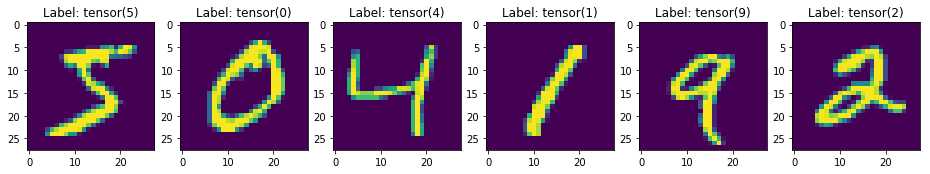

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title('Label: '+str(y_train_raw[i]))
    axes[i].imshow(x_train_raw[i])

Example labels

In [8]:
y_train = y_train_raw  # no conversions
y_test = y_test_raw
print('y_train:')
print('shape', y_train.shape)
print('data')
print(y_train[:20])

y_train:
shape torch.Size([60000])
data
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9])


Normalize and flatten images

In [9]:
x_train = (x_train_raw - x_train_raw.mean()) / x_train_raw.std()
x_test = (x_test_raw - x_train_raw.mean()) / x_train_raw.std()    # reuse mean/std from train set
x_train = x_train.view([len(x_train), -1])
x_test = x_test.view([len(x_test), -1])
print('x_train:')
print('shape', x_train.shape)
print('data')
print(x_train[0, 300:400])

x_train:
shape torch.Size([60000, 784])
data
tensor([-0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240,  1.3452,  2.7962,  1.9943, -0.3985, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.2840,
         1.9943,  2.7962,  0.4670, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240,  0.0215,  2.6435,  2.4398,  1.6125,
         0.9506, -0.4112, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240,
        -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4240, -0.4

Move dataset to GPU

In [10]:
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# PyTorch Model

Helper to calculate accuracy, opeartes on tensors

In [11]:
def accuracy(pred, tar): 
    return (pred == tar).float().mean()  # tensor!!

Simple multi-layer perceptron

In [12]:
model = nn.Sequential(
    nn.Linear(in_features=784, out_features=512),
    nn.ELU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=512, out_features=512),
    nn.ELU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=512, out_features=10),  # no softmax
)
model.to(device)
criterion = nn.CrossEntropyLoss()                 # softmax included in here
optimizer = torch.optim.Adam(model.parameters())
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ELU(alpha=1.0)
  (2): Dropout(p=0.2)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ELU(alpha=1.0)
  (5): Dropout(p=0.2)
  (6): Linear(in_features=512, out_features=10, bias=True)
)


Train model

In [13]:
batch_size = 1000
hist = { 'loss':[], 'acc':[] }

for epoch in range(5):
    indices = torch.randperm(len(x_train), device=device)          # randmly shuffled indices [0..59999]
    for i in range(0, len(x_train), batch_size):                   # i = 0, 1000, 2000, 3000, ...
        
        # Pick mini-batch
        x = x_train[indices[i:i+batch_size]]
        y = y_train[indices[i:i+batch_size]]

        # Zero gradients
        optimizer.zero_grad()

        # Train
        outputs = model(x)                                         # outputs is un-normalized, i.e. no softmax
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            _, predictions = torch.max(outputs, 1)                 # max(outputs) is the same as max(softmax(outputs))
            hist['acc'].append( accuracy(predictions, y).item() )
            hist['loss'].append( loss.item() )

Final result

In [14]:
with torch.no_grad():
    outputs = model(x_train)
    _, predictions = torch.max(outputs, 1)
    acc = accuracy(predictions, y_train).item() 
print(f'Accuracy on train set: {acc:.2f}')

Accuracy on train set: 0.98


In [15]:
with torch.no_grad():
    outputs = model(x_test)
    _, predictions = torch.max(outputs, 1)
    acc = accuracy(predictions, y_test).item() 
print(f'Accuracy on test set: {acc:.2f}')

Accuracy on test set: 0.97


Plot loss and accuracy over training period

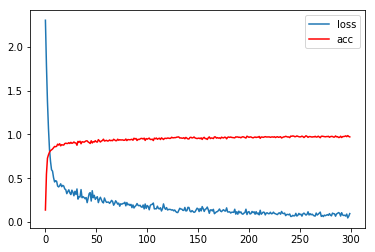

In [16]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['acc'], label='acc', color='red')
plt.legend();